# Nonlinear Langevin with Double-Welled Potential (Developement)

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [6]:
using PyPlot


include("DataGen.jl") # This has many packages in it's preamble
include("../../Tools/Model_Reduction.jl")

vector_wiener_filter_fft

In [2]:
steps = 10^6 + 1
scheme = "FE"
t_start = 0
t_stop = 10^4
discard = 100000
sig_init = [1.5]
sigma = [.5]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
e = randn(d,steps + discard)


X = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d, e
    )

T = range(t_start,stop = t_stop, length = steps)

h = T[2] - T[1]
gap = 1
Δt = gap*h

0.01

In [3]:
d, N = size(X)

nfft = nextfastfft(N)
X = [X zeros(d,nfft-N)]

1×1000188 Array{Float64,2}:
 0.962176  0.921578  0.999438  0.999068  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [7]:
Psi(x) = [x; x.^3]

n = 2
p = 300
ty = "bin"
par = 2000

h_wf = get_wf(X, Psi)

1×2×20 Array{Float64,3}:
[:, :, 1] =
 1.01162  -0.0104044

[:, :, 2] =
 -0.00255048  0.000884398

[:, :, 3] =
 0.00107504  -0.000610527

...

[:, :, 18] =
 -0.00197617  0.000769596

[:, :, 19] =
 0.00295489  -0.00112209

[:, :, 20] =
 -0.00130864  0.000759563

## Here we dive in to the sorce code to find the bug

### `get_wf'

In [27]:
# get_wf(
signal = X  # Vector valued process
Psi; # column vector valued function
M_out = 20
rl = true
Preds = false
PI = false
rtol = 1e-6
# )

# We would like a presample since we want the
# times series to be offset by one.

sig = signal[:,2:end] # sig is now one a head of signal
d, steps = size(sig)
nu = size(Psi(zeros(d,1)),1)

pred = complex(zeros(nu, steps))
for n = 1:steps
    pred[:,n] = Psi(signal[:,n])
end # pred is now even with signal and therefore one step
    # step behind sig. I.e. pred[:,n] = Psi(sig[:,n-1])
    # which is what we want so as to ensure the reduced
    # model can run explicitly.

### `vector_wiener_filter_fft` 

In [ ]:
# vector_wiener_filter_fft(

win = "Par"

# )

d, stepsy = size(sig)
nu, stepsx = size(pred)

stepsx == stepsy || print("X and Y are not the same length. Taking min.")
steps = minimum([stepsx stepsy])
nfft = nextfastfft(steps)
nffth = Int(floor(nfft/2))
L = 1500 #par

R_pred_smoothed = matrix_autocov_seq(pred,
   L = L,
   steps = steps,
   nu = nu,
   win = win
   )

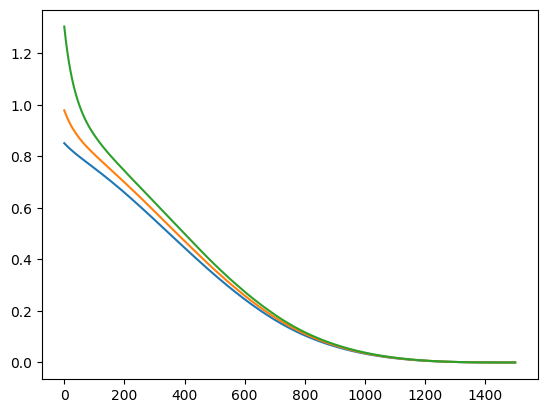

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001622908>
 PyObject <matplotlib.lines.Line2D object at 0x000000000164B988>
 PyObject <matplotlib.lines.Line2D object at 0x000000000164B048>

In [31]:
plot(real([R_pred_smoothed[1,1,
                :] R_pred_smoothed[1,2,
                :] R_pred_smoothed[2,2,:]]))

In [32]:
# Compute coefficients of spectral factorization of z-spect-pred
l = PI ? spectfact_matrix_CKMS_pinv(R_pred_smoothed,rtol = rtol) :
         spectfact_matrix_CKMS(R_pred_smoothed)

l_pad_minus = nfft >= L+1 ? cat(dims = 3,l,zeros(nu,nu,nfft - L - 1)) :
                           l[:,:,1:nfft]

z_spect_pred_minus_num_fft = fft(l_pad_minus,3)
z_spect_pred_plus_num_fft = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_plus_num_fft[:,:,i] = z_spect_pred_minus_num_fft[:,:,i]'
end

Number of CKMS iterations: 1963
errK errR : 9.784394316497059e-11 3.9150416379027426e-15


In [33]:
#recovered spectral density of pred
z_spect_pred_recoverd = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_recoverd[:,:,i] =z_spect_pred_minus_num_fft[:,:,i]*
                                  z_spect_pred_plus_num_fft[:,:,i]
end

z_spect_pred = z_crossspect_fft(pred, pred; nfft, n, p, ty);

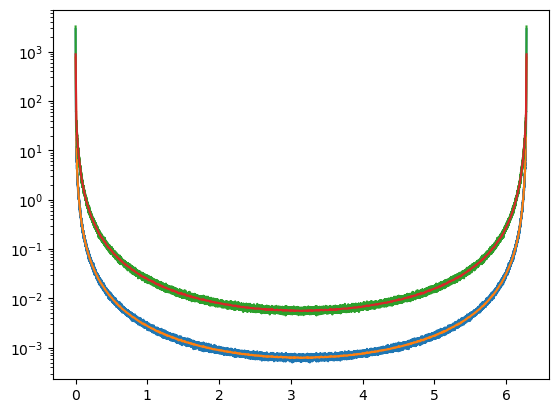

4-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000014E476888>
 PyObject <matplotlib.lines.Line2D object at 0x000000014E494948>
 PyObject <matplotlib.lines.Line2D object at 0x000000014E494788>
 PyObject <matplotlib.lines.Line2D object at 0x000000014E494D88>

In [35]:
semilogy(2π*(1:nfft)/nfft,[real(z_spect_pred[1,1,
                :]) real(z_spect_pred_recoverd[1,1,
                :]) real(z_spect_pred[2,2,
                :]) real(z_spect_pred_recoverd[2,2,
                :])]) # z_spect_pred[1,2,
                #:] z_spect_pred[2,2,:]]))
# axis([0,2000,-20,300])

In [36]:
# Compute z-cross-spectrum of sigpred
z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred;
                    nfft, n, p, ty);

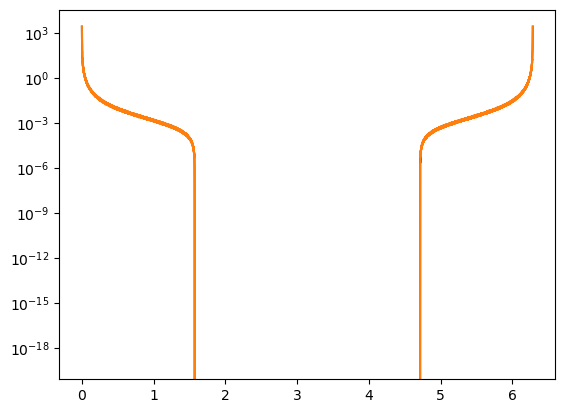

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000014E4C06C8>
 PyObject <matplotlib.lines.Line2D object at 0x000000014E4E24C8>

In [37]:
Theta = 2π*(1:nfft)/nfft

uz_spect_pred = zeros(2,2,nfft)
for i in 1:nfft
    uz_spect_pred[1,1,i] = real(exp(-Theta[i]*im).*z_spect_pred[1,1,i])
end

semilogy(2π*(1:nfft)/nfft,[real(z_crossspect_sigpred_num_fft[1,1,:]) uz_spect_pred[1,1,:]])

In [ ]:
# This computes the impule response (coefficeints of z) for S_{yx}{S_x^+}^{-1}
S_sigpred_overS_plus_fft_num = complex(zeros(d,nu,nfft))

for i = 1 : nfft
    S_sigpred_overS_plus_fft_num[:,:,i] = z_crossspect_sigpred_num_fft[:,:,i]/
                                          z_spect_pred_plus_num_fft[:,:,i]
end

S_sigpred_overS_plus_fft_num_fft = ifft(S_sigpred_overS_plus_fft_num,3)

# Extracts causal part coefficinets of S_{yx}{S_x^+}^{-1}, {S_{yx}{S_x^+}^{-1}}_+
S_sigpred_overS_plus_fft_plus_num_fft = cat(dims = 3,
                S_sigpred_overS_plus_fft_num_fft[:,:,1: nffth],
                zeros(d,nu,nfft - nffth))

# Computes causal part of S_{yx}/S_x^+, {S_{yx}/S_x^+}_+
S_sigpred_overS_plus_plus_num_fft = fft(S_sigpred_overS_plus_fft_plus_num_fft,3);

# Obtain transfer function H by dividing {S_{yx}/S_x^+}_+ by S_x^-

H_num = complex(zeros(d,nu,nfft))
for i = 1: nfft
    H_num[:,:,i] = S_sigpred_overS_plus_plus_num_fft[:,:,i]/
                   z_spect_pred_minus_num_fft[:,:,i]
end

# Extrct tranferfunction coeffifcients (impulse responce of Weiner filter)
h_num_raw = ifft(H_num, 3)

# Truncate
M_out > nfft && println("M_out > nfft, taking min")
M = min(M_out, nfft)
h_num_fft = h_num_raw[:,:,1:M]

In [50]:
h_wf = h_num_fft

h_wf = rl ? real(h_wf) : h_wf
Preds ? [h_wf, pred] : h_wf

1×2×20 Array{Float64,3}:
[:, :, 1] =
 7.1413  -1.9604

[:, :, 2] =
 -0.0885497  0.0259441

[:, :, 3] =
 -0.0853352  0.0245834

...

[:, :, 18] =
 -0.051224  0.0146673

[:, :, 19] =
 -0.0505626  0.0156287

[:, :, 20] =
 -0.0615373  0.0181053

In [19]:
Δt = (t_stop - t_start)/(steps - 1)
h_ana = zeros(1,2,10)
h_ana[:,:,1] = [1+Δt -Δt]

1×2 Array{Float64,2}:
 1.001  -0.001

### Get `Y_hat` the One-Step Predictions

In [10]:
pred = get_pred(X, Psi)


2×1000188 Array{Float64,2}:
 0.962176  0.921578  0.999438  0.999068  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.890767  0.782701  0.998314  0.997206     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [11]:
M_h = size(h_wf,3)

X_hat = zeros(size(X)); 
X_hat[:,1:M_h] = X[:,1:M_h]
for i=M_h:steps-1
    X_hat[:,i] = sum(h_wf[:,:,k+1]*pred[:,i-k]
                    for k = 0:M_h-1)
end

In [13]:
err = X - X_hat

Lags = -100:10
C1 = my_crosscov(pred[1,:],err[:],Lags)
C2 = my_crosscov(pred[2,:],err[:],Lags)


111-element Array{Float64,1}:
 0.0003707068127297572
 0.00037661300680464033
 0.0003825945737918894
 0.000388387962365289
 0.0003942495532238135
 0.00040038735804870005
 0.0004068625301717403
 0.00041330172384603013
 0.0004197220235645058
 0.0004261576719248463
 0.000432152538753729
 0.00043869907484143385
 0.0004448599081111179
 ⋮
 0.002688936200352161
 0.0027692746712589607
 0.0026924901221512835
 0.002620323380767608
 0.0025507931591760872
 0.002483981975112173
 0.002419825519339955
 0.0023582298957319603
 0.0022987196697852722
 0.00224121178017327
 0.0021859551260186598
 0.0021325850379936596

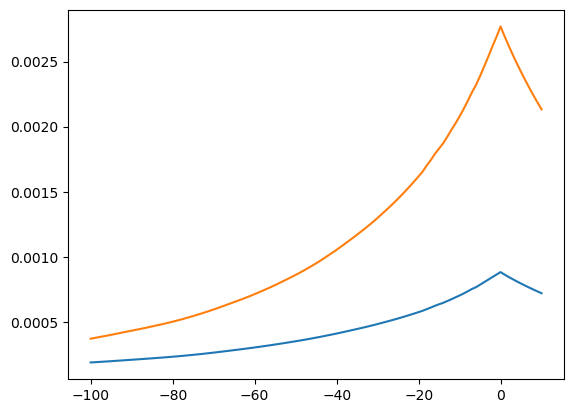

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000026D80C8>
 PyObject <matplotlib.lines.Line2D object at 0x00000000026E8448>

In [14]:
plot(Lags,real([C1 C2]))

### Run reduced model

In [18]:
d, N  = size(X)
nu    = size(Psi(X[:,1]),1) 
M_out = size(h_wf,3)
σ = sigma[1]

X_rm_n = zeros(d,N); X_rm_n[:,1:M_out] = X[:,1:M_out]

PSI_n = zeros(nu,N); 
for i = 1:M_out
    PSI_n[:,i] = Psi(X_rm_n[:,i])
end

for i = M_out + 1 : N
    X_rm_n[:,i] = sum(h_wf[:,:,k]*PSI_n[:,i-k] for k = 1:M_out, dims = 2) + sqrt(h)*σ*randn(d,1)
    PSI_n[:,i] = Psi(X_rm_n[:,i])
end

In [25]:
X_rm_n

1×1000188 Array{Float64,2}:
 0.962176  0.921578  0.999438  0.999068  …  0.8323  0.811666  0.812134

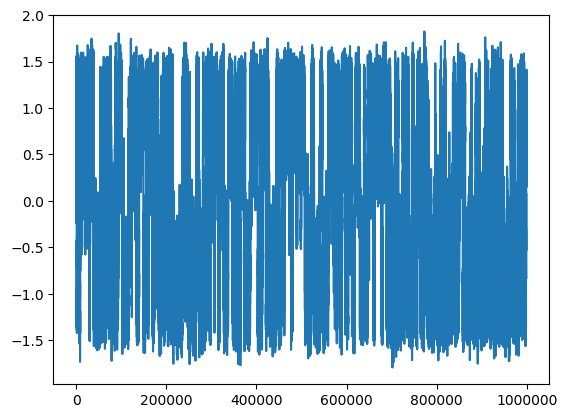

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004F4E8588>

In [26]:
plot(X_rm_n[1,:])

In [29]:
A = matrix_autocov_seq(X;L = 1500,win = "par")
A_rm_n = matrix_autocov_seq(X_rm_n;L = 1500,win = "par");

In [32]:
mean(X,dims = 2)
var(X,dims = 2)

1×1 Array{Float64,2}:
 0.8420151879594432

In [33]:
mean(X_rm_n,dims = 2)
var(X_rm_n,dims = 2)

1×1 Array{Float64,2}:
 0.8874523223640123

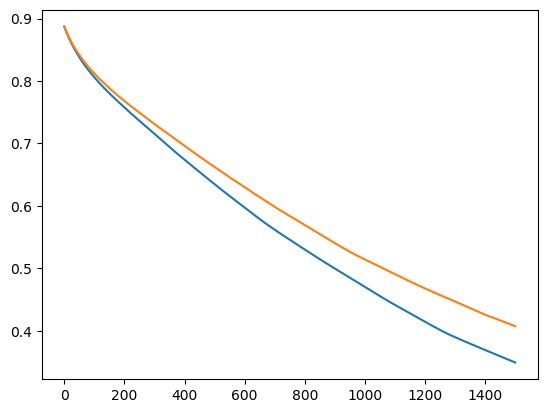

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000531871C8>
 PyObject <matplotlib.lines.Line2D object at 0x00000000531744C8>

In [31]:
plot(real([A[1,1,:].*A_rm_n[1,1,1]/A[1,1,1] A_rm_n[1,1,:]]))

In [28]:
function matrix_autocov_seq(pred;
    L = 1500,
    steps = size(pred,2),
    nu = size(pred,1),
    win = "Par"
    )

    lags = -L:L

    # Smoothed viewing window
    lam = _window(L, win = win, two_sided = false)

    R_pred_smoothed = zeros(Complex,nu,nu,length(0:L))
    for i = 1 : nu
        for j = 1 : nu
            temp = my_crosscov(pred[i,1:steps],pred[j,1:steps],lags)
            temp = .5*(temp[L+1:end] + conj(reverse(temp[1:L+1])))
            R_pred_smoothed[i,j,:] = lam .* temp
        end
    end
    R_pred_smoothed
end

matrix_autocov_seq (generic function with 1 method)